In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np 
from torchvision.datasets import MNIST
from scipy.spatial.distance import cdist
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split







In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the data to a tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the data to have mean 0.1307 and standard deviation 0.3081
])

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='../Data/Mnist_test_data/', train=True, download=True, transform=transform)
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='../Data/Mnist_test_data/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Train the VAE model

In [3]:

class VAE(nn.Module):
    def __init__(self, latent_dim=8):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [4]:
 # Loss function: reconstruction loss + KL divergence loss
def loss_function(x_hat, x, z_mean, z_logvar):
        bce_loss = nn.functional.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
        return bce_loss + kld_loss

In [5]:
# Define the VAE model
model = VAE()

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the training parameters
learning_rate = 1e-3
num_epochs = 50
batch_size = 128


# Define the training function
def train(model, train_loader, learning_rate, num_epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Loss function: reconstruction loss + KL divergence loss
    def loss_function(x_hat, x, z_mean, z_logvar):
        bce_loss = nn.functional.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
        return bce_loss + kld_loss

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, z_mean, z_logvar = model(x)
            loss = loss_function(x_hat, x, z_mean, z_logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        avg_loss = total_loss / len(train_loader.dataset)
        print('Epoch [{}/{}], Average Loss: {:.4f}'.format(epoch+1, num_epochs, avg_loss))

        # Generate and save a sample image every 5 epochs
        if (epoch+1) % 10 == 0:
            with torch.no_grad():
                z = torch.randn(64, model.latent_dim).to(device)
                sample = model.decode(z).view(64, 1, 28, 28)
                save_image(sample, 'vae_samples_epoch{}.png'.format(epoch+1))



In [22]:

# Train the VAE model using the train function
train(model, train_loader, learning_rate, num_epochs, device)

Epoch [1/50], Average Loss: 190.4579
Epoch [2/50], Average Loss: 142.7414
Epoch [3/50], Average Loss: 129.9615
Epoch [4/50], Average Loss: 122.9894
Epoch [5/50], Average Loss: 119.6468
Epoch [6/50], Average Loss: 117.4704
Epoch [7/50], Average Loss: 115.8725
Epoch [8/50], Average Loss: 114.5584
Epoch [9/50], Average Loss: 113.5797
Epoch [10/50], Average Loss: 112.7019
Epoch [11/50], Average Loss: 111.9480
Epoch [12/50], Average Loss: 111.3630
Epoch [13/50], Average Loss: 110.7469
Epoch [14/50], Average Loss: 110.3042
Epoch [15/50], Average Loss: 109.8084
Epoch [16/50], Average Loss: 109.4337
Epoch [17/50], Average Loss: 109.1056
Epoch [18/50], Average Loss: 108.7239
Epoch [19/50], Average Loss: 108.4885
Epoch [20/50], Average Loss: 108.1977
Epoch [21/50], Average Loss: 107.8715
Epoch [22/50], Average Loss: 107.6133
Epoch [23/50], Average Loss: 107.4322
Epoch [24/50], Average Loss: 107.2202
Epoch [25/50], Average Loss: 106.9976
Epoch [26/50], Average Loss: 106.7714
Epoch [27/50], Averag

In [23]:
torch.save(VAE.state_dict(model), '../Model/VAE_Mnist.pth')

In [42]:
VAE.load_state_dict(model, torch.load('../Model/VAE_Mnist.pth'))


<All keys matched successfully>

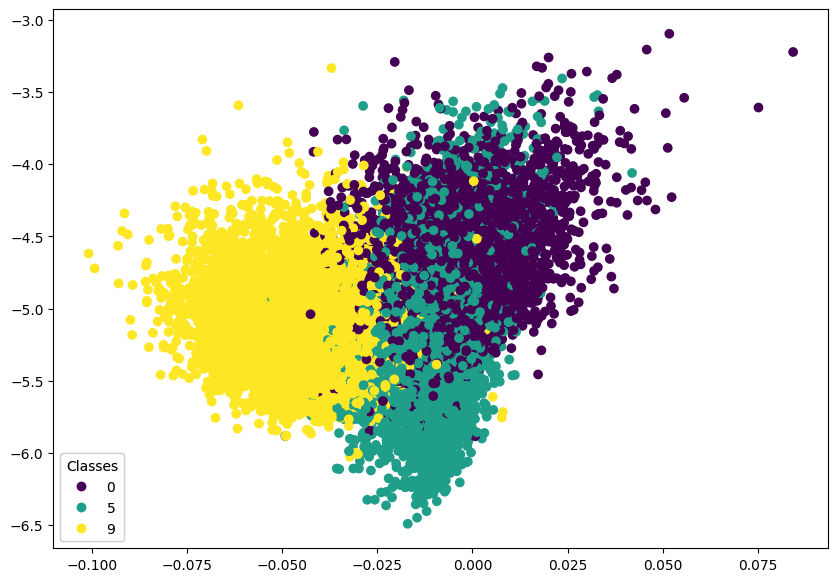

In [142]:

# Define the subset of MNIST data to visualize
indices = torch.where((mnist_train.targets == 0)  | (mnist_train.targets == 9)|(mnist_train.targets == 5))[0]
mnist_subset = mnist_train.data[indices]
mnist_subset_targets = mnist_train.targets[indices]

# Pass the subset to a DataLoader
batch_size = 64
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Visualize the latent vectors
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=mnist_subset_targets, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend)
plt.show()


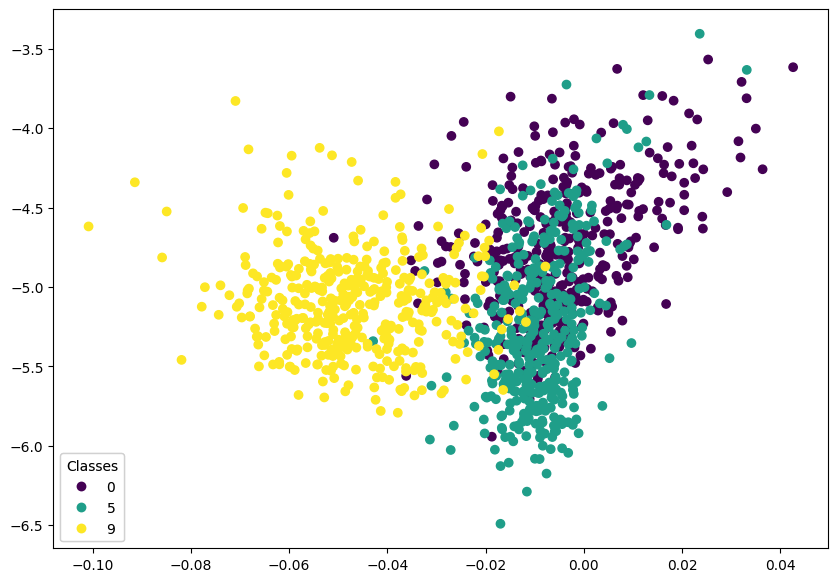

In [44]:
import random

# Define the subset of MNIST data to visualize
indices = torch.where((mnist_train.targets == 0)  | (mnist_train.targets == 9)|(mnist_train.targets == 5))[0]
mnist_subset = mnist_train.data[indices]
mnist_subset_targets = mnist_train.targets[indices]

# Select 500 samples from each class randomly
samples_per_class = 400
class_indices = []
for i in [0,  5,9]:
    class_i_indices = torch.where(mnist_subset_targets == i)[0]
    selected_indices = random.sample(class_i_indices.tolist(), samples_per_class)
    class_indices += selected_indices

# Use the selected indices to get the subset
mnist_subset = mnist_subset[class_indices]
mnist_subset_targets = mnist_subset_targets[class_indices]

# Pass the subset to a DataLoader
batch_size = 64
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Visualize the latent vectors
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=mnist_subset_targets, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend)
plt.show()


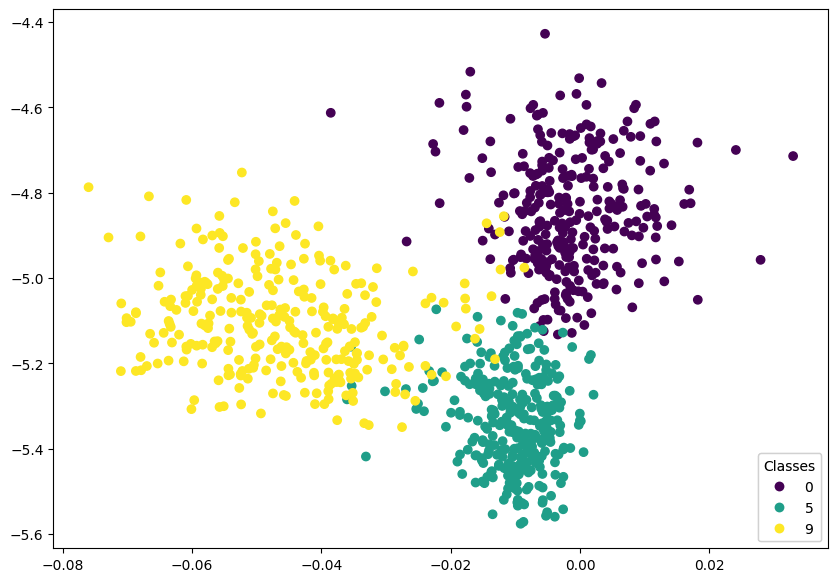

In [144]:
import torch
import numpy as np

# Define the subset of MNIST data to visualize
indices = torch.where((mnist_train.targets == 0)  | (mnist_train.targets == 9)|(mnist_train.targets == 5))[0]
mnist_subset = mnist_train.data[indices]
mnist_subset_targets = mnist_train.targets[indices]

# Pass the subset to a DataLoader
batch_size = 64
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Compute the mean of the latent vectors for each class
means = []
for i in [0,5,9]:
    class_indices = (mnist_subset_targets == i).nonzero().squeeze()
    class_vectors = latent_vectors[class_indices]
    mean = class_vectors.mean(dim=0)
    means.append(mean)

# Select x samples from each class that are close to the mean, but not too close
num_samples = 300
sample_indices = []
for i, mean in zip([0,5,9], means):
    class_indices = (mnist_subset_targets == i).nonzero().squeeze()
    class_vectors = latent_vectors[class_indices]
    distances = np.linalg.norm(class_vectors - mean.cpu().numpy(), axis=1)
    sorted_indices = np.argsort(distances)
    closest_indices = sorted_indices[:num_samples//2]
    farthest_indices = sorted_indices[num_samples//2:num_samples]
    sample_indices.extend(class_indices[closest_indices].tolist())
    sample_indices.extend(class_indices[farthest_indices].tolist())

# Select the samples from the subset and their corresponding targets
mnist_subset = mnist_subset[sample_indices]
mnist_subset_targets = mnist_subset_targets[sample_indices]

# Pass the subset to a DataLoader
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Visualize the latent vectors
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=mnist_subset_targets, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="lower right", title="Classes")
ax.add_artist(legend)
plt.show()


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import pandas as pd
from sklearn.decomposition import PCA

In [19]:
# Display plots inline and change default figure size
%matplotlib inline
# Train the logistic rgeression classifier
x = mnist_subset[:, :2]


mnist_subset.shape

torch.Size([900, 28, 28])

In [21]:
# Define the subset of MNIST data to visualize
indices = torch.where((mnist_train.targets == 0)  | (mnist_train.targets == 9)|(mnist_train.targets == 5))[0]
mnist_subset = mnist_train.data[indices]
mnist_subset_targets = mnist_train.targets[indices]


In [39]:
mnist_subset_targets.shape

torch.Size([1200])

In [156]:
from scipy.spatial import KDTree
from sklearn.neighbors import NearestNeighbors




# separate the dataset by class
class_0 = torch.where(mnist_subset_targets == 0)[0]
# Create a mask to filter out samples that are not in class 1
mask = (mnist_subset_targets != 0).squeeze()

# Select samples from latent space that are not in class 1
latent_space_not_0 = latent_vectors[mask]
latent_space_not_0 = latent_space_not_0[:,:2]

#random point from class0 
random_index = torch.randint(high=class_0.shape[0], size=(1,))  # Choose a random index
class_0_random = latent_vectors[random_index]
class_0_random= class_0_random[:,:2]


# Find the nearest neighbor of the point in class 0 among the other classes
nn = NearestNeighbors(n_neighbors=1)
nn.fit(latent_space_not_0)

distances, indices = nn.kneighbors(class_0_random)

nearest_neighbor = latent_space_not_0[indices[0]]
nearest_neighbor_label =  mnist_subset_targets[mask][indices[0]]

print("Nearest neighbor:", nearest_neighbor)
print("Nearest neighbor label:", nearest_neighbor_label)


Nearest neighbor: tensor([[-0.0178, -5.0124]])
Nearest neighbor label: tensor([9])


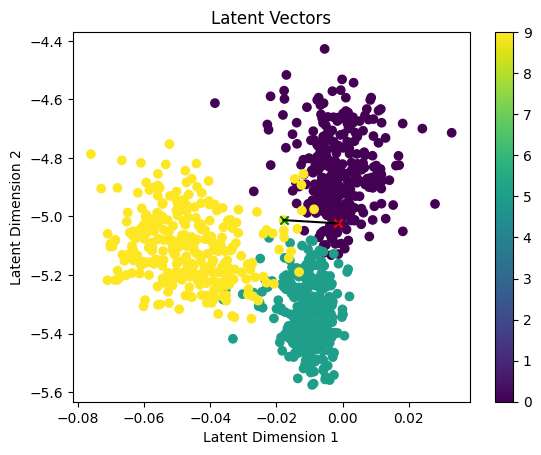

In [157]:
# Plot the full latent vectors in 2 dimensions
plt.scatter(latent_vectors[:,0], latent_vectors[:,1], c=mnist_subset_targets)
plt.colorbar()
plt.title('Latent Vectors')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

# Plot the random point from class 0
plt.scatter(class_0_random[0,0], class_0_random[0,1], c='r', marker='x')

# Plot the nearest neighbor from the other classes
plt.scatter(nearest_neighbor[0,0], nearest_neighbor[0,1], c='g', marker='x')

# Draw a line between the random point and its nearest neighbor
plt.plot([class_0_random[0,0], nearest_neighbor[0,0]], [class_0_random[0,1], nearest_neighbor[0,1]], c='k')

plt.show()

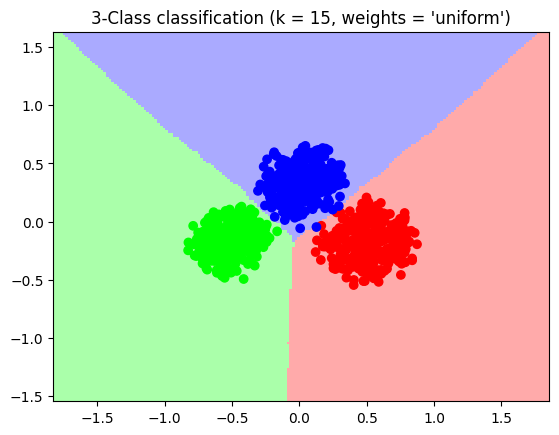

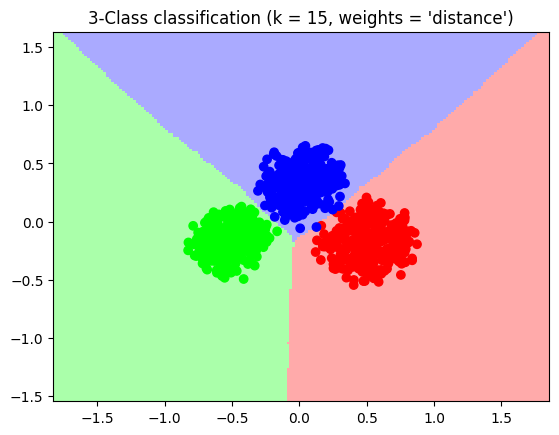

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15


X = X_pca[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = mnist_subset_targets

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

/var/folders/wt/pl8gm0gs50d6vpk0nxfh07_h0000gn/T/ipykernel_1712/1357344678.py:18: UserWarning: linewidths is ignored by contourf
  plt.contourf(xx, yy, Z, alpha=0.5, linewidths=5)


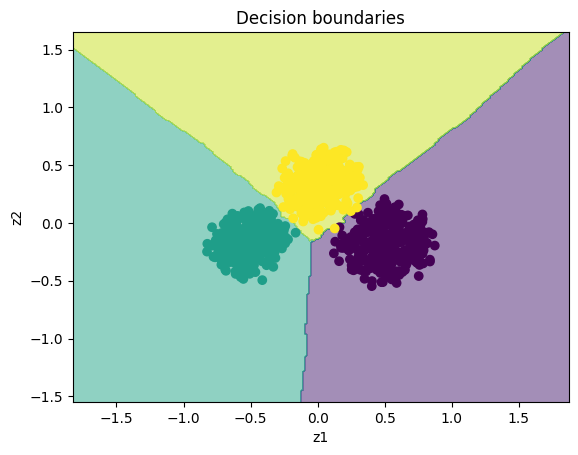

In [145]:
# Apply PCA to the data to reduce the dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(latent_vectors)

# Train a k-nearest neighbors classifier on the reduced data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_pca, mnist_subset_targets)

# Define a grid of points in the latent space
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 250), torch.linspace(y_min, y_max, 250))

# Flatten the grid of points and make predictions with the classifier
Z = knn.predict(torch.stack([xx.ravel(), yy.ravel()], axis=1)).reshape(xx.shape)

# Plot the decision boundaries and data points
plt.contourf(xx, yy, Z, alpha=0.5, linewidths=5)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=mnist_subset_targets)
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Decision boundaries')

plt.show()